<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
import os
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import DatasetFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
%matplotlib inline

# sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [2]:
# !kaggle datasets download -d imcr00z/flickr-faces-70k-thumbnails-128x128

In [3]:
# !nvidia-smi

In [4]:
%env NVIDIA_VISIBLE_DEVICES=2
%env CUDA_VISIBLE_DEVICES=1

!echo $NVIDIA_VISIBLE_DEVICES
!echo $CUDA_VISIBLE_DEVICES

env: NVIDIA_VISIBLE_DEVICES=2
env: CUDA_VISIBLE_DEVICES=1
2
1


In [5]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda', index=0)

In [6]:
class RealImageDataset(DatasetFolder):
    def __init__(self, *args, **kwargs):
        
        super().__init__(*args, **kwargs)
        
        
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, _ = self.samples[index]
        sample = self.loader(path)
        
        if self.transform is not None:
            sample = self.transform(sample)

        return sample

In [7]:
from PIL import Image
from sklearn.model_selection import train_test_split

def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

def get_dataloader(batch_size, folder_path, transforms):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object 
    """
    # TODO: resize images, convert them to tensors and build dataloader
    
    dataset = RealImageDataset(
        root=folder_path,
        transform=transforms,
        loader=pil_loader,
        extensions=('png')
    )
    
    train_idx, valid_idx = train_test_split(
        np.arange(len(dataset), dtype=np.int32),
        test_size=0.2
    )
    
    train_subset = Subset(dataset, train_idx)
    valid_subset = Subset(dataset, valid_idx)
    
    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        num_workers=40,
        shuffle=True
    )
    
    val_loader = DataLoader(
        valid_subset,
        batch_size=batch_size,
        num_workers=40
    )
  

    return train_loader, val_loader

In [8]:
BATCH_SIZE = 100

In [9]:
train_loader, val_loader = get_dataloader(
    batch_size=BATCH_SIZE,
    folder_path='thumbnails',
    transforms=tt.Compose([
            tt.ToTensor()
    ])
)

In [10]:
mean = (0.) * 3
meansq = (0.) * 3
for data in train_loader:
    mean += data.mean((0, 2, 3))
    meansq += (data**2).mean((0, 2, 3))
    
mean /= len(train_loader)
meansq /= len(train_loader)

std = torch.sqrt(meansq - mean**2)
print("mean: " + str(mean))
print("std: " + str(std))
print()

mean: tensor([0.5198, 0.4249, 0.3801])
std: tensor([0.2806, 0.2547, 0.2555])



## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [18]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        in_out_channels_list = [
            (3, 64), (64, 128), (128, 256), (256, 512)
        ] 
        
        conv_layers_list = nn.ModuleList()
        
        for idx, (in_channels, out_channels) in enumerate(in_out_channels_list):
            
            conv_layers_list.append(nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=9,
                    stride=2,
                    bias=False
                ))
            
            if idx < len(conv_layers_list) - 1:
                conv_layers_list.append(nn.Sequential(
                    nn.BatchNorm2d(out_channels),
                    nn.LeakyReLU(True)
                ))
        
        self.conv_layers = nn.Sequential(*conv_layers_list)
        
        self.fc = nn.Linear(512, 1)
        
    def forward(self, x):
        
        feats = self.conv_layers(x)
        
        return torch.sigmoid(self.fc(feats.squeeze()))
    
class Generator(nn.Module):
    def __init__(self, latent_dim=1024):
        super().__init__()
        
        channels_with_strides_list = [
            (256, 2), (256, 1), (256, 2), (256, 2),
            (128, 1), (64, 2)
        ] 
        
        in_channels = 8 * 8 * 512
        
        self.layers1d = nn.Sequential(
            nn.Linear(latent_dim, in_channels),
            nn.BatchNorm1d(in_channels),
        )
        
        layers2d_list = nn.ModuleList()
        
        for out_channels, stride in channels_with_strides_list:
            
            layers2d_list.append(nn.Sequential(
                nn.ConvTranspose2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=6,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(True)
            ))
            
            in_channels = out_channels
        
        self.layers2d = nn.Sequential(*layers2d_list)
        
        self.last_conv = nn.ConvTranspose2d(
            in_channels=in_channels,
            out_channels=3,
            kernel_size=3,
            stride=1
        )
        
        self.activation = nn.Tanh()
        
    def forward(self, x):
        
        vec_output = self.layers1d(x)
        
        im_input = vec_output.view(vec_output.shape[0], vec_output.shape[1], 1, 1)
        
        out = self.layers2d(im_input)
        
        return self.activation(self.last_conv(out))

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [19]:
from torchmetrics.image.fid import FrechetInceptionDistance as fid_metric
from torch.optim import Adam
import torch.nn.functional as F
import pytorch_lightning as pl
import wandb

class LitGAN(pl.LightningModule):
    def __init__(
        self,
        n_epochs,
        lr_g,
        beta_g,
        lr_d,
        beta_d,
        latent_dim=1024
    ):
        super().__init__()
        
        self.save_hyperparameters()
        
        self.generator = Generator(latent_dim=1024)
        self.discriminator = Discriminator()
        
#         self.val_FID = fid_metric(feature=64)
        
        self.validation_z = torch.randn(8, self.hparams.latent_dim)
        
        self.uniform_sampler = torch.distributions.uniform.Uniform(0, 0.05)
        
#         self.tensor2image = lambda x: wandb.Image
            
    def forward(self, x):
        
        return self.generator(x)
    
    def configure_optimizers(self):
        opt_g = Adam(
            self.generator.parameters(),
            lr=self.hparams.lr_g,
            betas=(self.hparams.beta_g, 0.999)
        )
#         scheduler = CosineAnnealingLR(opt_g, T_max=self.n_epochs//3, eta_min=1e-8)
        opt_d = Adam(
            self.discriminator.parameters(),
            lr=self.hparams.lr_d,
            betas=(self.hparams.beta_d, 0.999)
        )
    
        return [opt_g, opt_d], []#scheduler]
    
    def adversarial_loss(self, y_hat, y):
        return nn.BCELoss()(y_hat, y)
    
    def training_step(self, train_batch, batch_idx, optimizer_idx):
        x = train_batch
        
        z = torch.randn(x.shape[0], self.hparams.latent_dim)
        z = z.type_as(x)
        
        if optimizer_idx == 0:
            
            generated_imgs = self(z)

#             sample_imgs = self.generated_imgs[:6]
#             grid = make_grid(sample_imgs)
#             self.logger.log_image('generated_images', [self.tensor2image(grid.detach().cpu())], 0)

            labels = torch.ones(x.size(0), 1)
            labels = labels.type_as(x)

            g_loss = self.adversarial_loss(self.discriminator(generated_imgs), labels)
            self.log('g_loss', g_loss, on_step=True, on_epoch=False)#, prog_bar=True)
            
            return g_loss
        
        if optimizer_idx == 1:
            
            generated_imgs = self(z)

            labels = torch.ones(x.size(0), 1)
            labels = labels.type_as(x)

            real_loss = self.adversarial_loss(self.discriminator(x), labels)

            fake_labels = torch.zeros(x.size(0), 1)
            fake_labels = fake_labels.type_as(x)
            
            fake_labels += self.uniform_sampler.sample([x.size(0), 1]).to(fake_labels.device)

            fake_loss = self.adversarial_loss(self.discriminator(generated_imgs), fake_labels)

            d_loss = (real_loss + fake_loss) / 2
            self.log('d_loss', d_loss, on_step=True, on_epoch=False)#, prog_bar=True)
            
            return d_loss

    def on_train_epoch_end(self):
        z = self.validation_z
        
        with torch.no_grad():

            grid = make_grid(self(z.to(self.device)))# * 255).long()
            plt.title('generated_samples')
  
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            plt.axis('off')
            plt.show()

#         self.val_FID.update(sample_imgs, real=False)
        
#         self.log('self.val_FID', self.val_FID.compute())

In [20]:
import gc

# wandb.finish()
gc.collect(), torch.cuda.empty_cache()

(26835, None)

In [21]:
N_EPOCHS = 100

In [25]:
model = LitGAN(
    lr_g=1e-3,
    lr_d=5e-3,
    beta_g=0.5,
    beta_d=0.5,
    n_epochs=N_EPOCHS
).to(DEVICE)

In [26]:
from pytorch_lightning.callbacks import ModelCheckpoint

wb_logger = pl.loggers.WandbLogger(
    name=f'LSGAN_bce|n_epochs={N_EPOCHS}|bs={BATCH_SIZE}|+noise|bce|all_data_fix',
    project='GANs'
)

checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    monitor='g_loss',
    filename='{epoch:02d}-{g_loss:.3f}',
    mode='min'
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 344 M 
1 | discriminator | Discriminator | 14.0 M
------------------------------------------------
358 M     Trainable params
0         Non-trainable params
358 M     Total params
1,432.600 Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


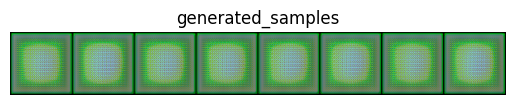

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


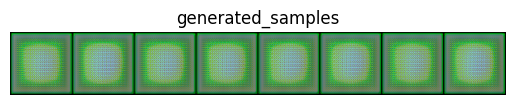

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


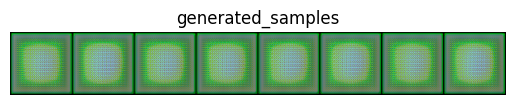

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


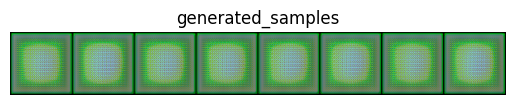

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


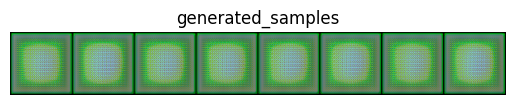

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


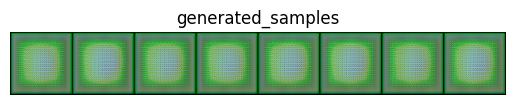

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


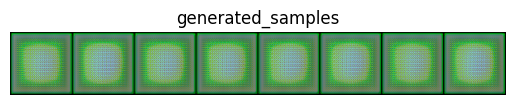

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


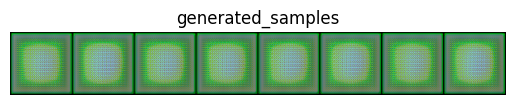

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


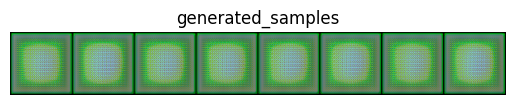

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


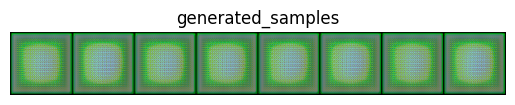

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


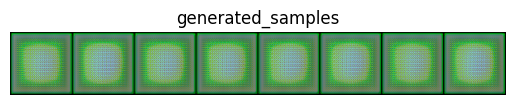

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


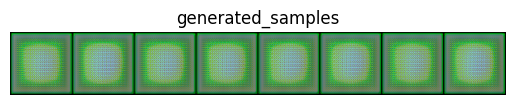

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd9c2288d30>
Traceback (most recent call last):
  File "/home/v_chernyy/myvenv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/v_chernyy/myvenv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd9c2288d30>
Traceback (most recent call last):
  File "/home/v_chernyy/myvenv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/v_chernyy/myvenv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdo

    self._shutdown_workers()
  File "/home/v_chernyy/myvenv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd9c2288d30>
Traceback (most recent call last):
  File "/home/v_chernyy/myvenv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/v_chernyy/myvenv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
E

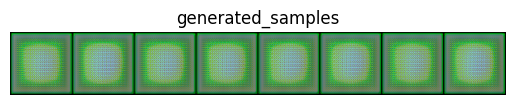

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd9c2288d30>
Traceback (most recent call last):
  File "/home/v_chernyy/myvenv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/v_chernyy/myvenv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd9c2288d30>
Traceback (most recent call last):
  File "/home/v_chernyy/myvenv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/v_chernyy/myvenv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdo


can only test a child processcan only test a child process:   File "/home/v_chernyy/myvenv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers

    can only test a child processself._shutdown_workers()

if w.is_alive():
    
  File "/home/v_chernyy/myvenv/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
      File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():if w.is_alive():


AssertionError  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
:         can only test a child processassert self._parent_pid == os.getpid(), 'can only test a child process'assert self._parent_pid == os.getpid(), 'can only test a child process'


AssertionErrorAssertionError: : can only test

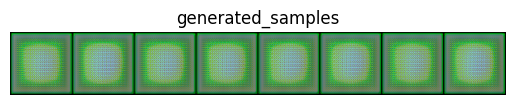

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


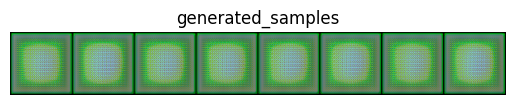

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


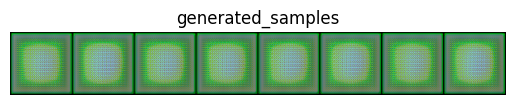

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


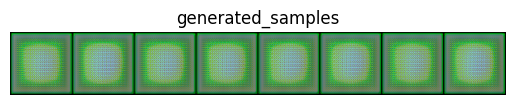

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


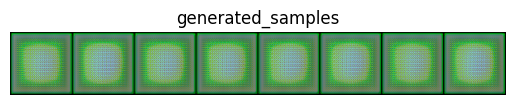

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


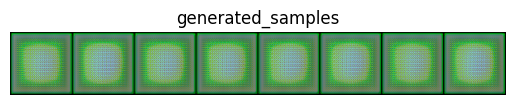

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


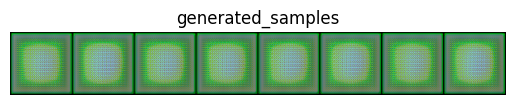

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


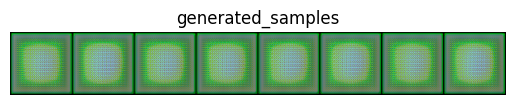

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


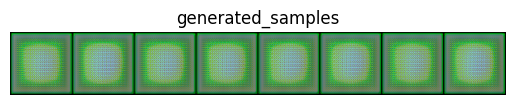

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


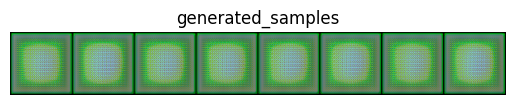

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


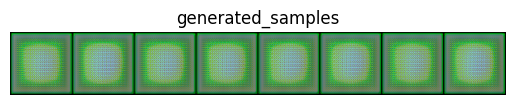

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


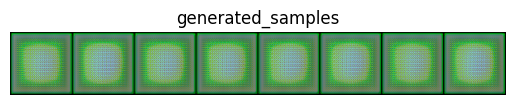

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


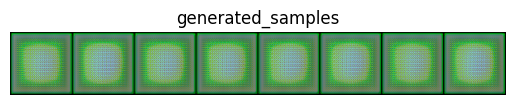

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


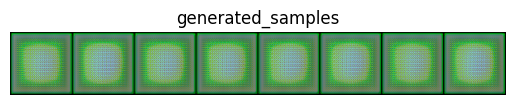

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


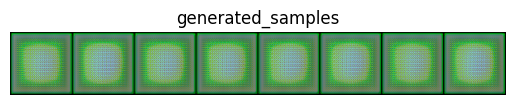

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


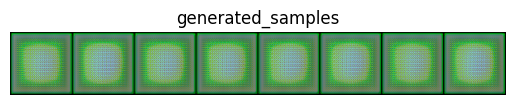

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


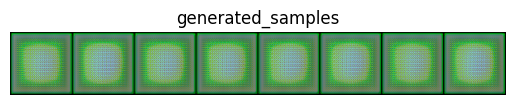

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


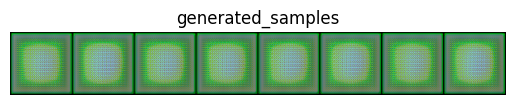

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


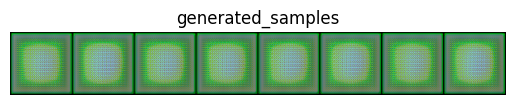

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


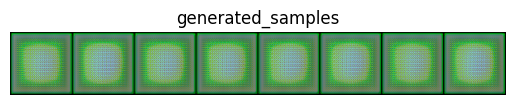

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


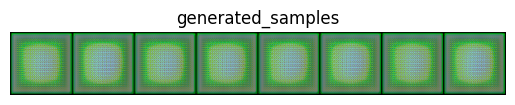

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


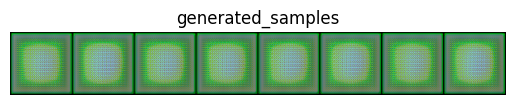

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


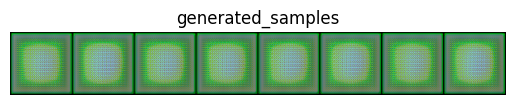

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


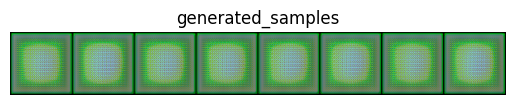

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


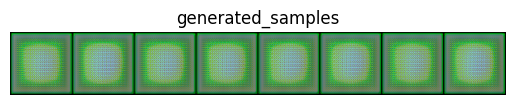

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


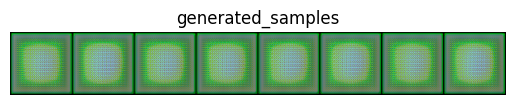

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


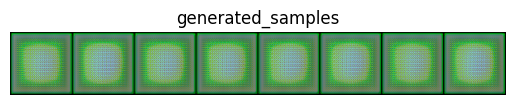

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


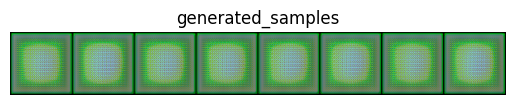

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


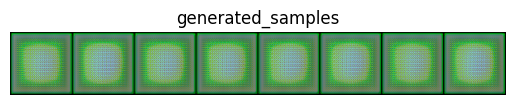

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


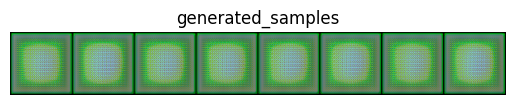

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


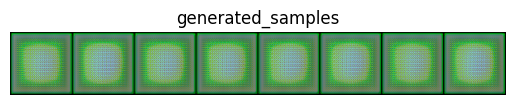

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


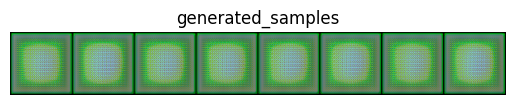

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


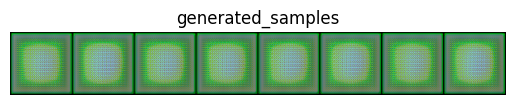

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [ ]:
trainer = pl.Trainer(
    max_epochs=N_EPOCHS,
    accelerator='gpu',
    devices=1,
    benchmark=True,
#     callbacks=[checkpoint_callback],
#     enable_progress_bar=True,
#     log_every_n_steps=len(train_loader),
    logger=wb_logger
)

trainer.fit(
    model = model,
    train_dataloaders = train_loader,
#     val_dataloaders = val_loader
)

wandb.finish()

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [32]:
model.eval()
pass

In [38]:
n_images = 4

fixed_latent = torch.randn(n_images, 1024, device='cpu')

with torch.no_grad():
    print(fixed_latent.device)
    fake_images = model.generator(fixed_latent)

cpu


In [50]:
def show_images(generated):
  
    plt.imshow(make_grid(generated).permute(1, 2, 0))
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


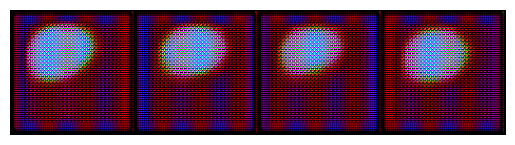

In [51]:
show_images(fake_images)

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

Прокомментируйте получившийся результат: